# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure. Each machine failed immediately after the last recorded timestamp in the remote monitoring timeseries data.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

In [427]:
#!pip3 install statsmodels
#!pip3 install ipdb
#!pip3 install seaborn
#!pip3 install rpy2
#!pip3 install lifelines

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,message
count,305
unique,2
top,warning
freq,304


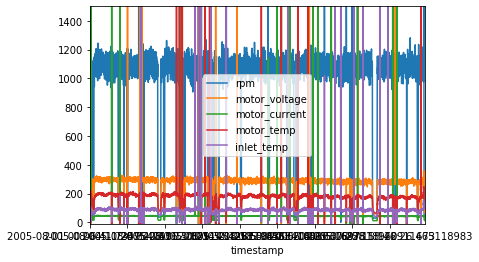

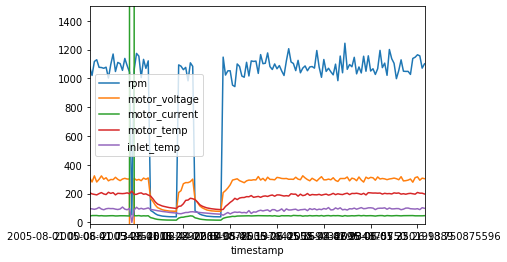

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

import lifelines as ll
import seaborn as sns
%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp")
    
def load_alarms(filename):
    return pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp")

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500))

display(rms.describe())
display(alarms.describe())

## Data processing

In [48]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from lifelines import KaplanMeierFitter
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot
import itertools

import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import numpy as np
from sklearn.model_selection import train_test_split

plotly.tools.set_credentials_file(username='kempegowda.a', api_key='cF870W5z9vOzGeP0O5iv')

In [3]:
class RMS(object):
    
    def __init__(self, rms_path=None, alarm_path=None):
        if rms_path is not None:
            self.load_rms(rms_path)
        if alarm_path is not None:
            self.load_alarms(alarm_path)
        
    def load_rms(self, filename):
        self.rms = pd.read_csv(filename, index_col="timestamp")
        self.rms_processed = pd.read_csv(filename, index_col="timestamp")
        self.rms_processed.reset_index(level=0, inplace=True)
        self.rms_processed = self.rms_processed.dropna(axis=0)
        
    def assign_cleaned_df(self, df):
        self.noise_free_rms = df
    
    def load_alarms(self, filename):
        self.alarm = pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp")
        self.alarm_processed = pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp")
        self.alarm_processed.reset_index(level=0, inplace=True)
        self.alarm_processed = self.alarm_processed.dropna(axis=0)

    def plotly_rms_ts(self, df, title= None):
        rpm = go.Scatter(
            x=df.index,
            y=df['rpm'],
            name = "RPM",
            line = dict(color = '#17BECF'),
            opacity = 0.8)
        motor_voltage = go.Scatter(
            x=df.index,
            y=df['motor_voltage'],
            name = "Motor Voltage",
            line = dict(color = '#7F7F7F'),
            opacity = 0.8)
        motor_current = go.Scatter(
            x=df.index,
            y=df['motor_current'],
            name = "Motor Current",
            line = dict(color = '#d62728'),
            opacity = 0.8)
        motor_temp = go.Scatter(
            x=df.index,
            y=df['motor_temp'],
            name = "Motor Temperature",
            line = dict(color = '#e377c2'),
            opacity = 0.8)
        inlet_temp = go.Scatter(
            x=df.index,
            y=df['inlet_temp'],
            name = "Inlet Temperature",
            line = dict(color = '#ff7f0e'),
            opacity = 0.8)
        motor_data = [rpm,motor_voltage, motor_current, motor_temp,inlet_temp]
        layout = dict(
            title=title,
            xaxis=dict(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                             label='1m',
                             step='month',
                             stepmode='backward'),
                        dict(count=12,
                             label='30m',
                             step='month',
                             stepmode='backward'),
                        dict(step='all')
                    ])
                ),
                rangeslider=dict(
                    visible = True
                ),
                type='date'
            )
        )
        fig = dict(data=motor_data, layout=layout)
        return py.iplot(fig, filename = title)

In [4]:
class HelperFunction(object):

    def remove_outliers(self, sensor, custom_range = [0.05, 0.95]):
        self.df = sensor.loc[:, sensor.columns != 'Index']
        self.quantile = self.df.quantile(custom_range)
        return self.outlier_lambda(custom_range)
    
    def outlier_lambda(self, custom_range):
        clean_df = self.df.apply(
            lambda element: element[
                (element > self.quantile.loc[custom_range[0],element.name]) & 
                (element < self.quantile.loc[custom_range[1],element.name])], 
            axis=0)
        clean_df = clean_df.dropna(axis=0)
        return clean_df
    
    def generate_file_paths(self, iter_range,is_train=True):
        ds = 'train' if is_train else 'test' 
        paths_dict = {}
        for i in range(iter_range[0],iter_range[1]): 
            paths_list=[]
            key = 'sensor'+str(i)
            unit_id = str(i).zfill(4)
            gen_rms_file_path = 'data/'+ ds +'/unit' + unit_id  +'_rms.csv'
            gen_alarm_file_path = 'data/'+ ds +'/unit'+ unit_id +'_alarms.csv'
            paths_list.append(gen_rms_file_path)
            paths_list.append(gen_alarm_file_path)
            paths_dict[key] = paths_list
        return paths_dict

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1191cc9e8>,
      dtype=object)

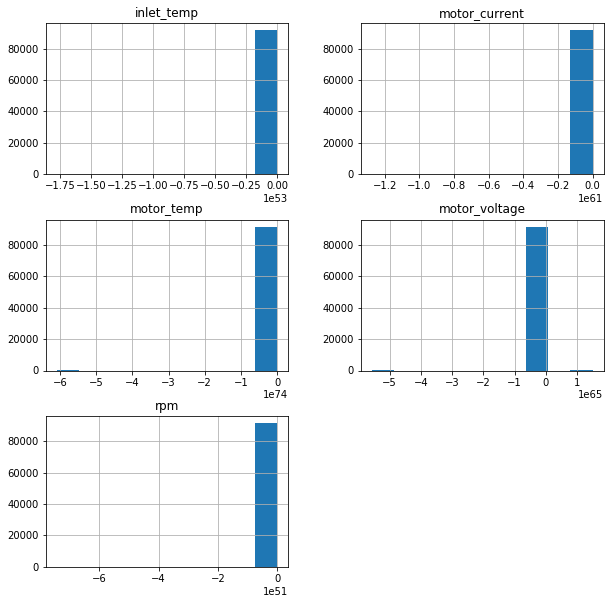

In [5]:
rms.hist(figsize=(10,10))

In [6]:
units = [0,20]
helper = HelperFunction()
file_paths = helper.generate_file_paths(units)
file_paths

{'sensor0': ['data/train/unit0000_rms.csv', 'data/train/unit0000_alarms.csv'],
 'sensor1': ['data/train/unit0001_rms.csv', 'data/train/unit0001_alarms.csv'],
 'sensor2': ['data/train/unit0002_rms.csv', 'data/train/unit0002_alarms.csv'],
 'sensor3': ['data/train/unit0003_rms.csv', 'data/train/unit0003_alarms.csv'],
 'sensor4': ['data/train/unit0004_rms.csv', 'data/train/unit0004_alarms.csv'],
 'sensor5': ['data/train/unit0005_rms.csv', 'data/train/unit0005_alarms.csv'],
 'sensor6': ['data/train/unit0006_rms.csv', 'data/train/unit0006_alarms.csv'],
 'sensor7': ['data/train/unit0007_rms.csv', 'data/train/unit0007_alarms.csv'],
 'sensor8': ['data/train/unit0008_rms.csv', 'data/train/unit0008_alarms.csv'],
 'sensor9': ['data/train/unit0009_rms.csv', 'data/train/unit0009_alarms.csv'],
 'sensor10': ['data/train/unit0010_rms.csv', 'data/train/unit0010_alarms.csv'],
 'sensor11': ['data/train/unit0011_rms.csv', 'data/train/unit0011_alarms.csv'],
 'sensor12': ['data/train/unit0012_rms.csv', 'data

In [7]:
helper.generate_file_paths([20,50], False)

{'sensor20': ['data/test/unit0020_rms.csv', 'data/test/unit0020_alarms.csv'],
 'sensor21': ['data/test/unit0021_rms.csv', 'data/test/unit0021_alarms.csv'],
 'sensor22': ['data/test/unit0022_rms.csv', 'data/test/unit0022_alarms.csv'],
 'sensor23': ['data/test/unit0023_rms.csv', 'data/test/unit0023_alarms.csv'],
 'sensor24': ['data/test/unit0024_rms.csv', 'data/test/unit0024_alarms.csv'],
 'sensor25': ['data/test/unit0025_rms.csv', 'data/test/unit0025_alarms.csv'],
 'sensor26': ['data/test/unit0026_rms.csv', 'data/test/unit0026_alarms.csv'],
 'sensor27': ['data/test/unit0027_rms.csv', 'data/test/unit0027_alarms.csv'],
 'sensor28': ['data/test/unit0028_rms.csv', 'data/test/unit0028_alarms.csv'],
 'sensor29': ['data/test/unit0029_rms.csv', 'data/test/unit0029_alarms.csv'],
 'sensor30': ['data/test/unit0030_rms.csv', 'data/test/unit0030_alarms.csv'],
 'sensor31': ['data/test/unit0031_rms.csv', 'data/test/unit0031_alarms.csv'],
 'sensor32': ['data/test/unit0032_rms.csv', 'data/test/unit0032_

In [8]:
def get_test_or_train_sensors(units, file_paths = None):
    if file_paths:
        sensors = []
#         import ipdb;ipdb.set_trace()
        for each_sensor in range(units[0], units[1]):
            sensor_var = 'sensor' + str(each_sensor) 
            sensor_obj = RMS(rms_path=file_paths.get(sensor_var)[0], alarm_path = file_paths.get(sensor_var)[1])
            rms_cleaned_df = helper.remove_outliers(sensor_obj.rms)
            sensor_obj.assign_cleaned_df(rms_cleaned_df)
            sensor_obj.noise_free_rms_processed = sensor_obj.noise_free_rms
            sensor_obj.noise_free_rms_processed.reset_index(level=0, inplace=True)
            sensor_obj.noise_free_rms_processed['timestamp'] = pd.to_datetime(sensor_obj.noise_free_rms_processed['index'], 
                                                                              format="%Y-%m-%d %H:%M:%S")
            sensor_obj.noise_free_rms_processed['power'] = sensor_obj.noise_free_rms_processed['motor_voltage'] *  sensor_obj.noise_free_rms_processed['motor_voltage']
            sensor_obj.noise_free_rms_processed['temp_diff'] = sensor_obj.noise_free_rms_processed['motor_temp'] -  sensor_obj.noise_free_rms_processed['inlet_temp']

            sensors.append(sensor_obj)
            del sensor_obj
        return sensors

In [9]:
sensors = get_test_or_train_sensors([0,20],helper.generate_file_paths(units))

In [10]:
test_sensors = get_test_or_train_sensors([20,50], helper.generate_file_paths([20,50], False))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1347e0a20>,
      dtype=object)

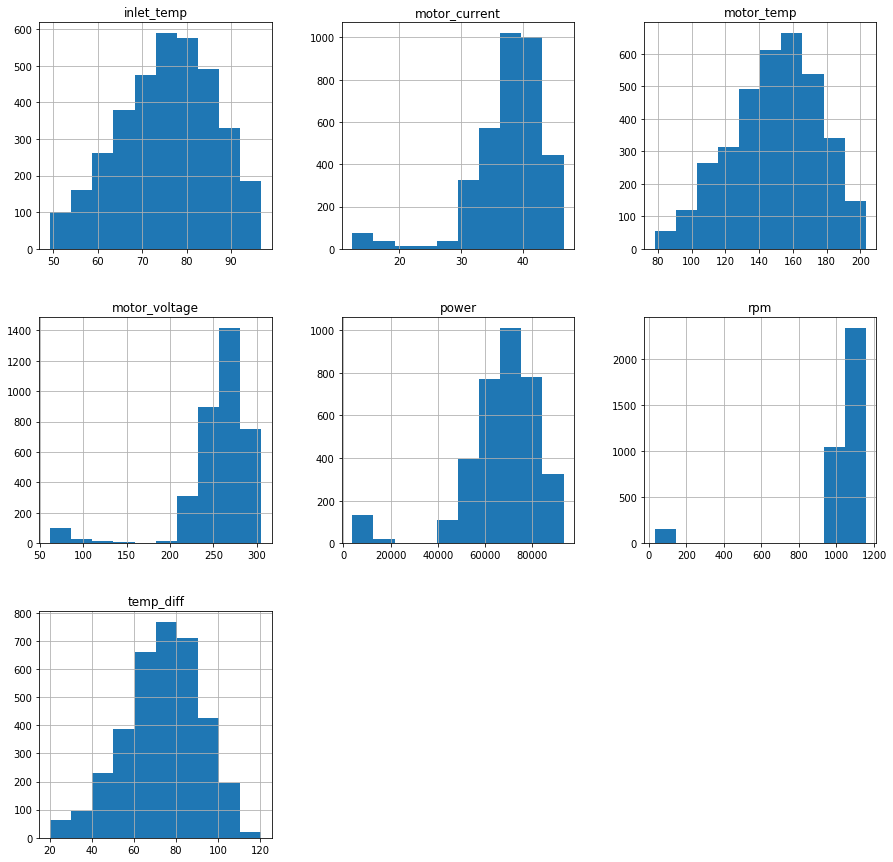

In [11]:
test_sensors[0].noise_free_rms_processed.hist(figsize=(15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13326de80>,
      dtype=object)

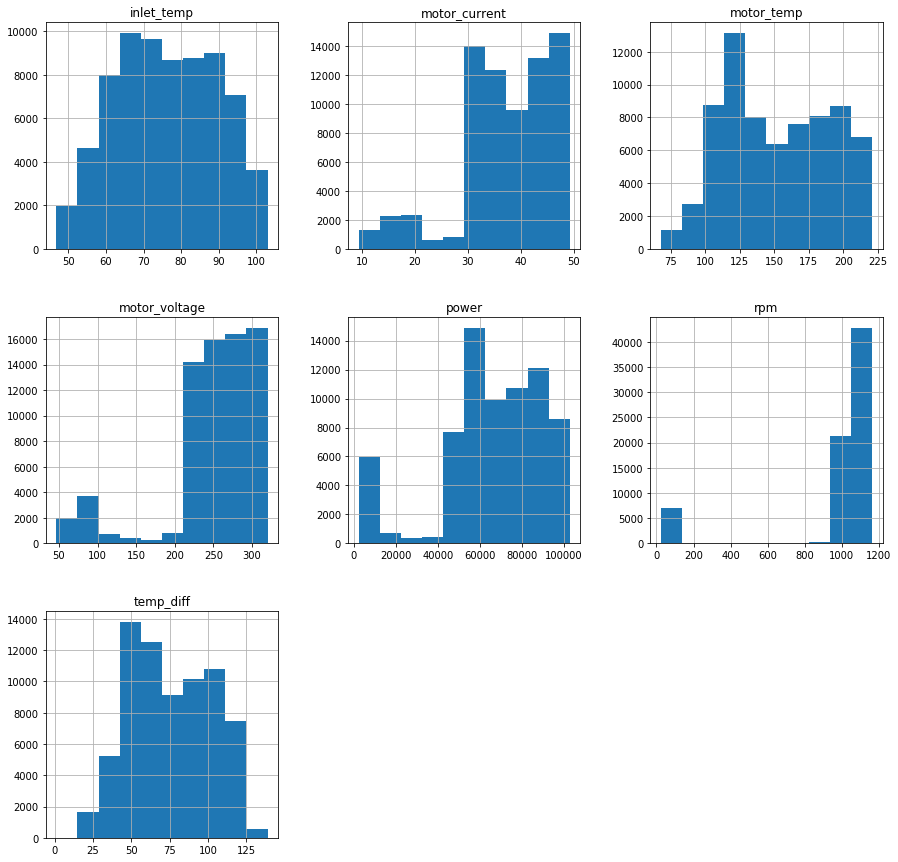

In [12]:
sensors[0].noise_free_rms_processed.hist(figsize=(15,15))

In [13]:
sensors[2].plotly_rms_ts(sensors[2].noise_free_rms_processed, title = "Sensor2: Denoised")

/Users/ajeyakempegowda/.virtualenvs/tagup/lib/python3.6/site-packages/IPython/core/display.py:694: UserWarning:

Consider using IPython.display.IFrame instead



In [8]:
sensors[9].plotly_rms_ts(sensors[9].noise_free_rms_processed, title = "Sensor9: Denoised")

The draw time for this plot will be slow for clients without much RAM.


/Users/ajeyakempegowda/.virtualenvs/tagup/lib/python3.6/site-packages/chart_studio/api/v1/clientresp.py:44: UserWarning:

Estimated Draw Time Slow



In [9]:
sensors[19].plotly_rms_ts(sensors[19].noise_free_rms_processed, title = "Sensor19: Denoised")

The draw time for this plot will be slow for all clients.


/Users/ajeyakempegowda/.virtualenvs/tagup/lib/python3.6/site-packages/chart_studio/api/v1/clientresp.py:44: UserWarning:

Estimated Draw Time Too Long



In [14]:
def plot_heatmaps(sensor):
    cols = ['rpm', 'motor_voltage', 'motor_current', 'motor_temp', 'inlet_temp']

    f = plt.figure(figsize=(10, 10))
    plt.matshow(sensor.noise_free_rms_processed[cols].corr(), fignum=f.number)
    plt.xticks(range(len(cols)), cols, fontsize=14, rotation=90)
    plt.yticks(range(len(cols)), cols, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)

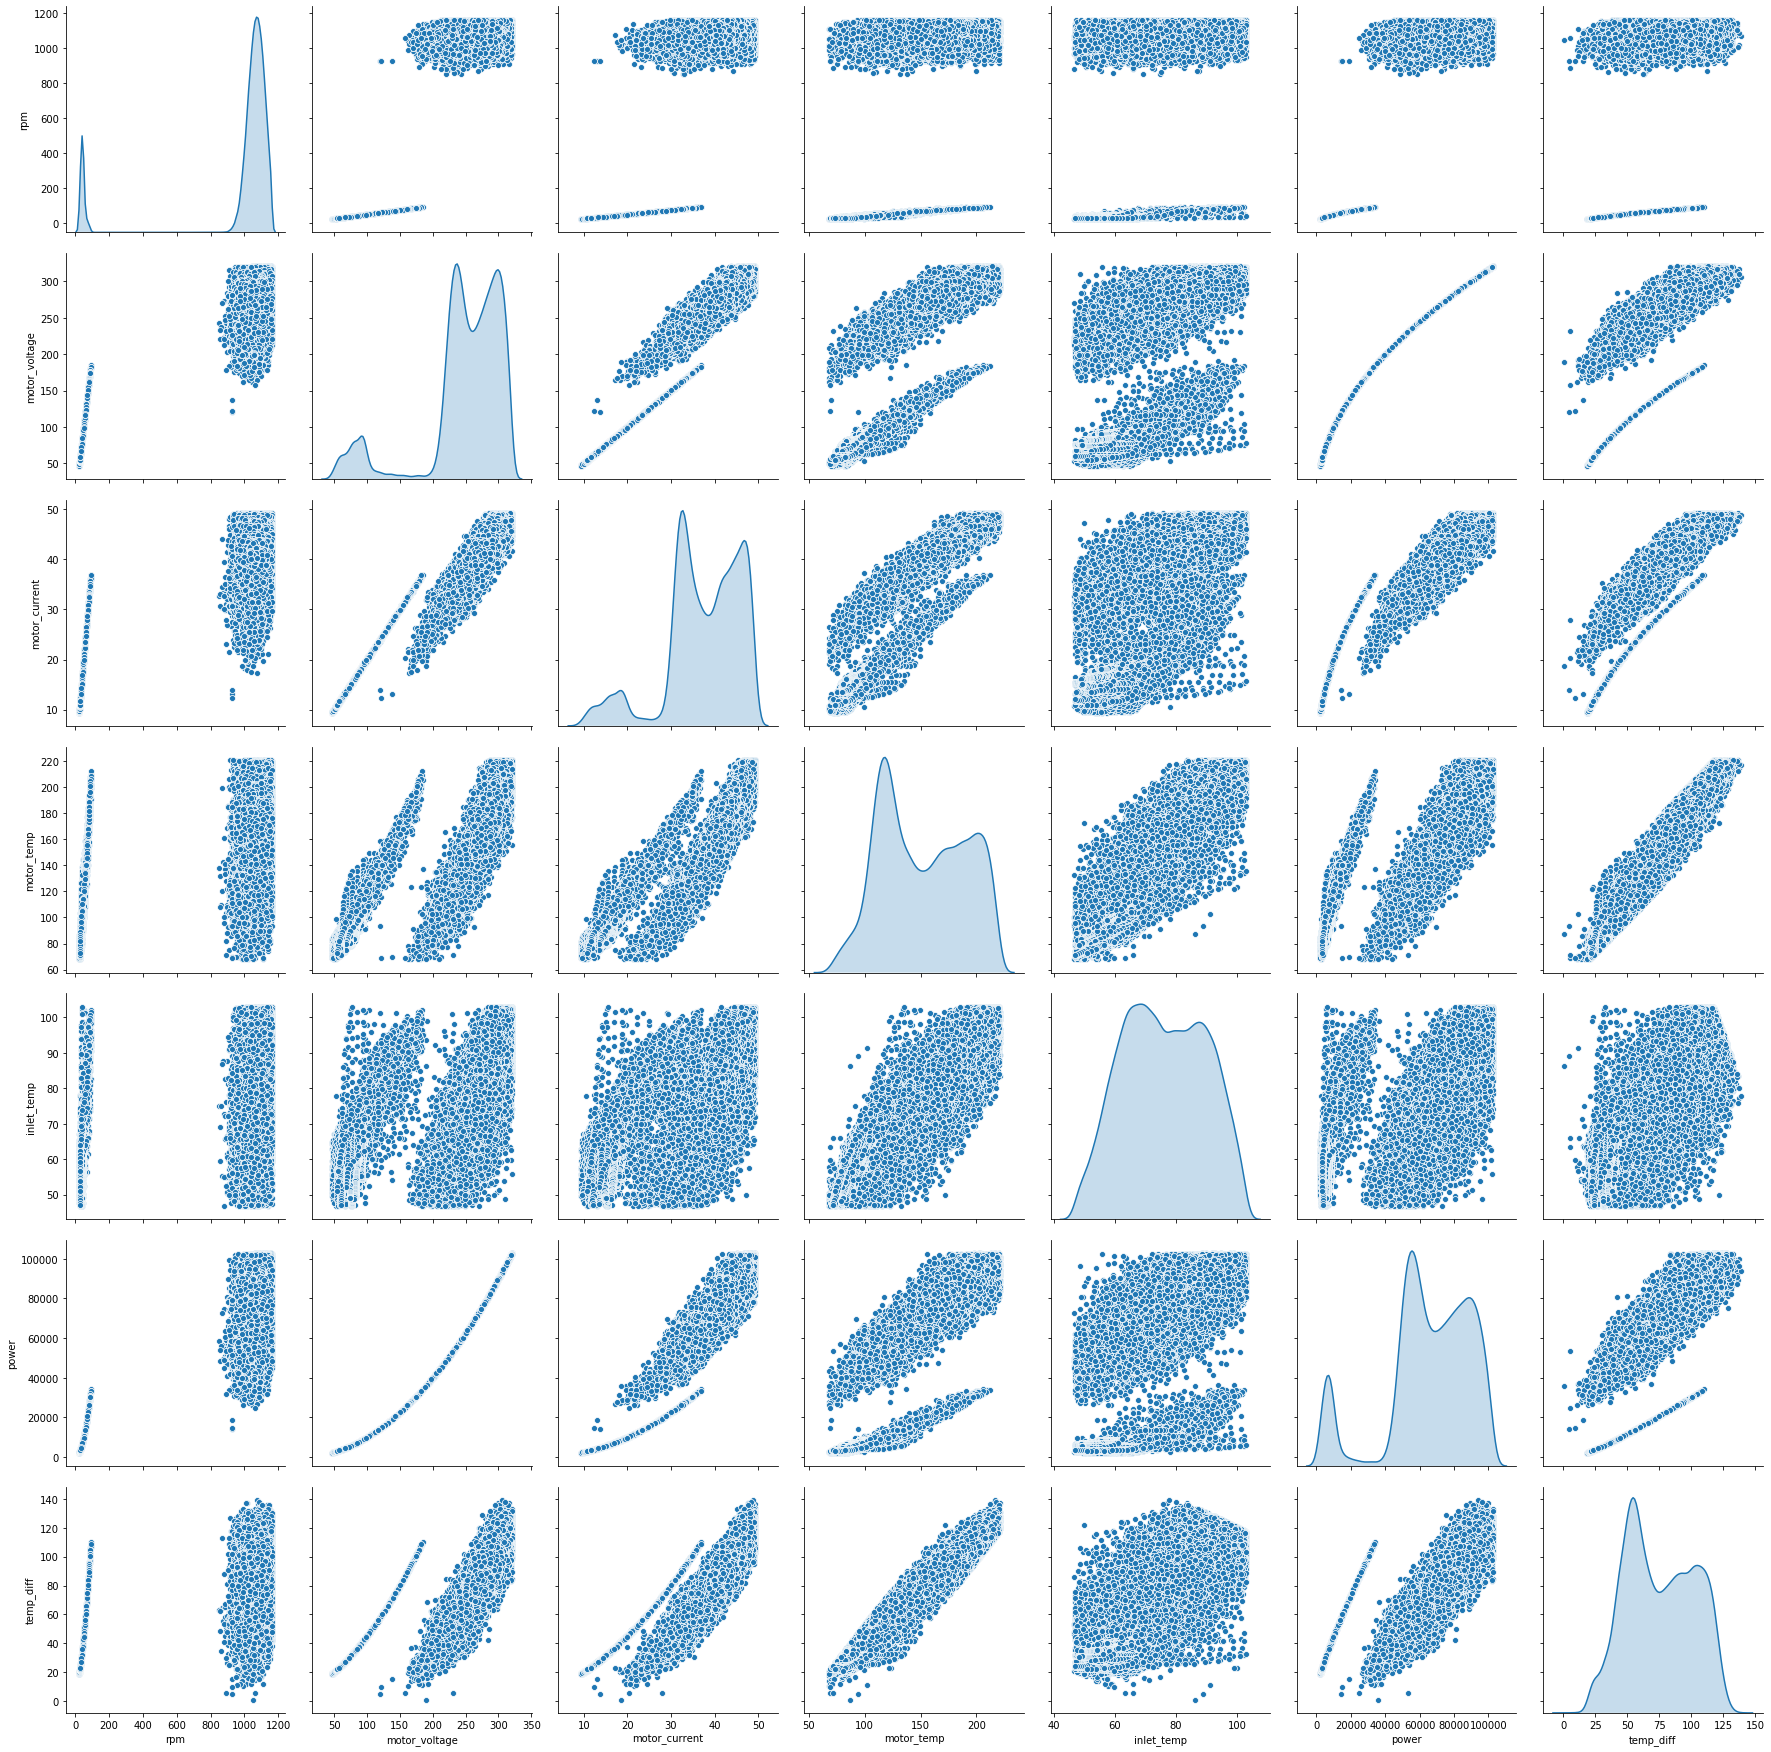

In [15]:
sns.pairplot(sensors[0].noise_free_rms_processed,  palette="Set2", diag_kind="kde", height=3.5)

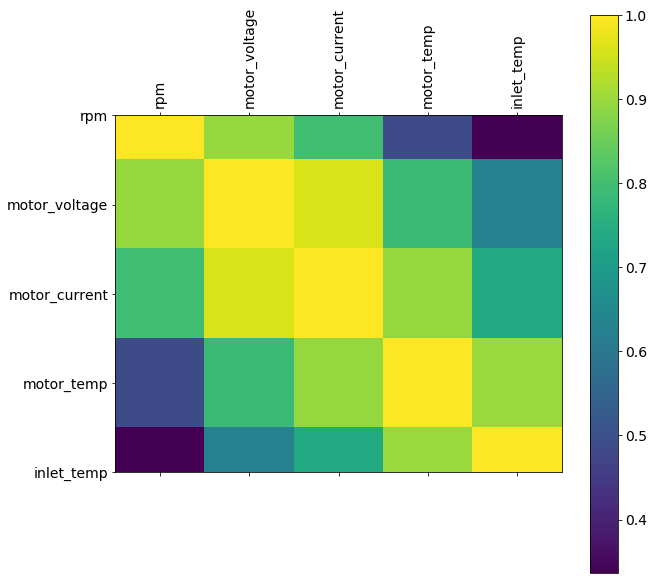

In [16]:
plot_heatmaps(sensors[1])

In [17]:
frames = []
for i in sensors:
    frames.append(i.noise_free_rms_processed)
result = pd.concat(frames)
result.head()

temp_df = result[:30000]

In [18]:
result.shape

(775374, 9)

In [19]:
def create_3d_plot(x, y, z):
    trace1 = go.Scatter3d(x=x,y=y,z=z,mode='markers',marker=dict(size=12,colorscale='Viridis',opacity=0.8))
    data = [trace1]
    layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename='3d-scatter-colorscale')

In [20]:
create_3d_plot(x=temp_df['rpm'],y=temp_df['power'],z=temp_df['temp_diff'])

In [190]:
create_3d_plot(x=temp_df['rpm'],y=temp_df['motor_current'],z=temp_df['temp_diff'])

/Users/ajeyakempegowda/.virtualenvs/tagup/lib/python3.6/site-packages/IPython/core/display.py:694: UserWarning:

Consider using IPython.display.IFrame instead



## Survival modeling
#### Reference: https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

In [21]:
def get_working_days(sensors):
    working_life = []
    v_std, i_std, p_std = [], [], []
    for each_s in sensors:
        desc = each_s.noise_free_rms_processed.describe()
        working_life.append(
            (each_s.noise_free_rms_processed['timestamp'].max()-
             each_s.noise_free_rms_processed['timestamp'].min()).days)
        v_std.append(desc['motor_voltage']['std'])
        i_std.append(desc['motor_current']['std'])
        p_std.append(desc['power']['std'])
    return working_life, v_std, i_std, p_std
sensor_life, v_std, i_std, p_std = get_working_days(sensors)

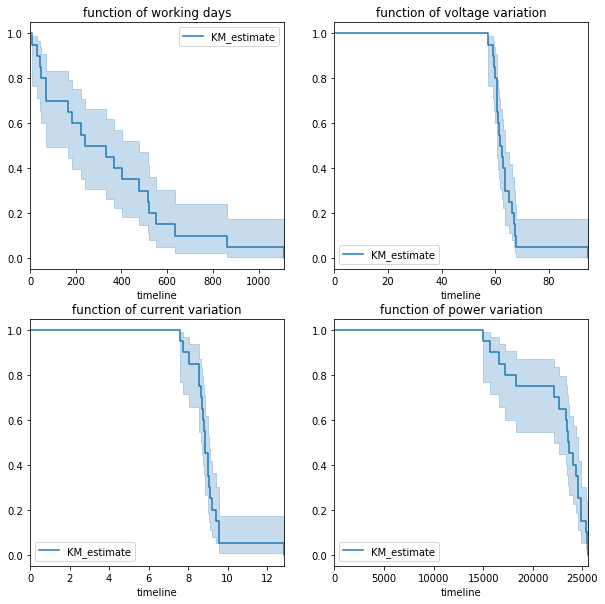

In [23]:
from lifelines import KaplanMeierFitter
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.reshape(4,)
titles = ["function of working days",
         "function of voltage variation",
         "function of current variation",
         "function of power variation"]
for i, model in enumerate([sensor_life, v_std, i_std, p_std]):
    axes[i].set_title(titles[i])
    KaplanMeierFitter(alpha=0.1).fit(durations = model, event_observed = [1]*len(model)).plot(ax=axes[i],)
plt.show()

In [192]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sc = StandardScaler()
clus = KMeans(n_clusters = 2, init = "k-means++")
nd = sc.fit_transform(sensors[0].noise_free_rms_processed[cols])
clus.fit(nd)

abcd = clus.predict(test_sensors[0].noise_free_rms_processed[cols])

In [195]:
print(len(abcd))

3547


In [ ]:
np.random.seed(5)

fig = tools.make_subplots(rows=2, cols=3,
                          print_grid=False,
                          specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d': True}],
                                 [ {'is_3d': True, 'rowspan':1}, None, None]])
scene = dict(
    camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2.5, y=0.1, z=0.1)
    ),
    xaxis=dict(
        range=[-1, 4],
        title='Petal width',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    yaxis=dict(
        range=[4, 8],
        title='Sepal length',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    zaxis=dict(
        range=[1,8],
        title='Petal length',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    )
)

centers = [[1, 1], [-1, -1], [1, -1]]

X = sensors[0].noise_free_rms_processed
y = iris.target

estimators = {'k_means_iris_3': KMeans(n_clusters=3),
              'k_means_iris_8': KMeans(n_clusters=8),
              'k_means_iris_bad_init': KMeans(n_clusters=3, n_init=1,
                                              init='random')}
fignum = 1
for name, est in estimators.items():
    est.fit(X)
    labels = est.labels_

    trace = go.Scatter3d(x=X[:, 3], y=X[:, 0], z=X[:, 2],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                color=labels.astype(np.float),
                                line=dict(color='black', width=1)
        ))
    fig.append_trace(trace, 1, fignum)
    
    fignum = fignum + 1

y = np.choose(y, [1, 2, 0]).astype(np.float)

trace1 = go.Scatter3d(x=X[:, 3], y=X[:, 0], z=X[:, 2],
                      showlegend=False,
                      mode='markers',
                      marker=dict(
                            color=y,
                            line=dict(color='black', width=1)))
fig.append_trace(trace1, 2, 1)

fig['layout'].update(height=900, width=900,
                     margin=dict(l=10,r=10))

fig['layout']['scene1'].update(scene)
fig['layout']['scene2'].update(scene)
fig['layout']['scene3'].update(scene)
fig['layout']['scene4'].update(scene)
fig['layout']['scene5'].update(scene)

In [25]:
sensors[0].noise_free_rms_processed.columns

Index(['index', 'rpm', 'motor_voltage', 'motor_current', 'motor_temp',
       'inlet_temp', 'timestamp', 'power', 'temp_diff'],
      dtype='object')

In [26]:
cols = ['rpm', 'motor_voltage', 'motor_current', 'motor_temp','inlet_temp', 'power', 'temp_diff']
temp_df[cols].head()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,power,temp_diff
0,1071.265218,220.091101,29.917097,89.069642,53.178325,48440.092657,35.891317
1,1121.121953,220.294005,30.317449,91.668490,50.227658,48529.448573,41.440831
2,1134.563007,216.858225,28.690638,93.489985,47.439531,47027.489960,46.050455
3,1127.632611,215.315746,29.825574,87.256581,49.198645,46360.870373,38.057936
4,1059.858213,233.556643,29.929805,95.151337,49.309509,54548.705515,45.841828


### ARIMA Approach

In [65]:
X = []
y = []

rms_norm = sensors[0].noise_free_rms_processed[cols][:5000]
lookback = 30  # look 10 hours behind, predict the next hour
for i in range(lookback, len(rms_norm)):
    X.append(rms_norm.iloc[i-lookback:i].values)
    y.append(rms_norm['rpm'].iloc[i])
    
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], len(rms_norm.columns)))

In [67]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=False)

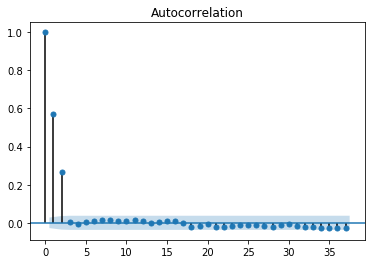

In [75]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(rms_norm['rpm'])
plt.show()

In [69]:
cols = ['rpm', 'motor_voltage', 'motor_current', 'motor_temp','inlet_temp',  'power', 'temp_diff']
data = pd.Series(sensors[0].noise_free_rms_processed['rpm'])
model = ARIMA(Xtrain,order=(2, 1, 2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())
qqplot(residuals)
print(model)

ValueError: endog must be 1-d or 2-d with 1 column

In [76]:
model_fit.plot_diagnostics(figsize=(20, 14))

AttributeError: 'ARIMAResults' object has no attribute 'plot_diagnostics'

In [197]:
y_train = pd.DataFrame(index = range(20), columns = range(1))
for x in range(20):
    y_train.iloc[x] = 1
y_train

,0
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [188]:
model.predict(sensors[17].noise_free_rms_processed['rpm'])

array([ -723497.77048694, -1114031.82400371, -1151217.85143663, ...,
                     nan,               nan,               nan])

In [79]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def evaluate_arima_model(X, arima_order):
#     import ipdb;ipdb.set_trace()
    train_size = int(len(X) * 0.66)
    train, test = train_test_split(te, test_size=0.34)
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test.iloc[t])
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.3f' % (order,mse))
                except Exception as e:
                    print(e.args)
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
# evaluate parameters
p_values = [0,1,2, 3, 4, 5]
d_values = range(0, 4)
q_values = range(0, 4)

In [ ]:
warnings.filterwarnings("ignore")
evaluate_models(sensors[0].noise_free_rms_processed['rpm'][:50], p_values, d_values, q_values)

(0, 0, 0)
ARIMA(0, 0, 0) MSE=2643.894
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
('The computed initial MA coefficients are not invertible\nYou should induce invertibility, choose a different model order, or you can\npass your own start_params.',)
(0, 1, 3)
('The computed initial MA coefficients are not invertible\nYou should induce invertibility, choose a different model order, or you can\npass your own start_params.',)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
('The computed initial MA coefficients are not invertible\nYou should induce invertibility, choose a different model order, or you can\npass your own start_params.',)
(0, 2, 3)
('The computed initial MA coefficients are not invertible\nYou should induce invertibility, choose a different model order, or you can\npass your own start_params.',)
(0, 3, 0)
('d > 2 is not supported',)
(0, 3, 1)
('d > 2 is not supported',)
(0, 3, 2)
('d > 2 is not supported',)
(0, 3, 3)
('d > 2 is not supported',)
(1, 0, 0)
ARIMA(1, 0, 0) MSE=255

https://stats.stackexchange.com/questions/71802/variable-selection-in-time-series-forecasting

https://www.researchgate.net/post/How_can_I_make_a_time-series_stationary

http://people.duke.edu/~rnau/Slides_on_ARIMA_models--Robert_Nau.pdf

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(predictions)
plt.plot(ytest)
plt.ylabel('Motor RPM')
plt.xlabel('Index')
plt.legend(['predictions', 'actual'])
plt.show()